In [2]:
import pandas as pd
import spacy
import glob
import os
from collections import Counter 
import numpy as np
from spacy.lang.en import English
from spacy.lookups import Lookups
from spacy.pipeline import EntityRuler
from spacytextblob.spacytextblob import SpacyTextBlob
import json
import sklearn
import matplotlib.pyplot as plt

In [3]:
def load_data(file):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data


all_files = glob.glob("../data/*.json")
print(all_files)

li = []
for file in all_files:
    data = pd.read_json(file)
    li.append(data)

temp = pd.concat(li, ignore_index=True)
df = temp[["tweet_id", "tweet_text"]]
print(df)

#d_types = load_data("../data/disasters/disaster_types.json")

['../data/california_wildfires_final_data.json', '../data/hurricane_harvey_final_data.json', '../data/hurricane_irma_final_data.json', '../data/hurricane_maria_final_data.json', '../data/iraq_iran_earthquake_final_data.json', '../data/mexico_earthquake_final_data.json', '../data/srilanka_floods_final_data.json']
                 tweet_id                                         tweet_text
0      917791044158185472  RT @Gizmodo: Wildfires raging through Northern...
1      917791130590183424      PHOTOS: Deadly wildfires rage in California  
2      917791291823591424  RT @Cal_OES: PLS SHARE: Were capturing wildfir...
3      917791291823591424  RT @Cal_OES: PLS SHARE: Were capturing wildfir...
4      917792092100988928  RT @TIME: California's raging wildfires as you...
...                   ...                                                ...
18077  881714673157980160                Get to mora and try the whole menu 
18078  881749861871362048  Mirka Mora (b.1928), noted French-born Aust

In [44]:
#load gazetteer

columns = [
    "geonameid",
    "name",
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "featureClass",
    "featureCode",
    "countryCode",
    "cc2",
    "admin1Code",
    "admin2Code",
    "admin3Code",
    "admin4Code",
    "population",
    "elevation",
    "dem",
    "timezone",
    "modificationDate"
]

dtypes = {
    "geonameid": "int64",
    "name": "string",
    "asciiname": "string",
    "alternatenames": "string",
    "latitude": "float64",
    "longitude": "float64",
    "featureClass": "string",
    "featureCode": "string",
    "countryCode": "string",
    "cc2": "string",
    "admin1Code": "string",
    "admin2Code": "string",
    "admin3Code": "string",
    "admin4Code": "string",
    "population": "int64",
    "elevation": "float64",      # or "Int64" if you want nullable integer
    "dem": "int64",
    "timezone": "string",
    "modificationDate": "string" # Could parse as date later doesn't matter too much though
}

gazetteer_df = pd.read_csv("../data/US.txt", 
                           sep="\t",
                          names=columns,
                          dtype=dtypes,
                          header=None,
                          low_memory=False)

gazetteer_df["alternate_list"] = gazetteer_df["alternatenames"] \
    .fillna("") \
    .apply(lambda x: x.split(","))

print(gazetteer_df.head())

   geonameid                 name            asciiname  alternatenames  \
0    2130830          Middle Reef          Middle Reef            <NA>   
1    2130833        McArthur Reef        McArthur Reef            <NA>   
2    2130890          Buldir Reef          Buldir Reef            <NA>   
3    3577483          The Narrows          The Narrows     The Narrows   
4    3715657  Cape Lookout Shoals  Cape Lookout Shoals  Lookout Shoals   

   latitude  longitude featureClass featureCode countryCode   cc2 admin1Code  \
0  51.98414  176.01982            U         RFU          US  <NA>         AK   
1  52.06667  177.86667            U         RFU          US  <NA>         AK   
2  52.15229  176.35675            U         RFU          US  <NA>         AK   
3  18.37502  -64.72517            H         CHN          US    VG         00   
4  34.51206  -76.49326            H        SHOL          US  <NA>         NC   

  admin2Code admin3Code admin4Code  population  elevation   dem  \
0      

In [53]:
#standardize locations thru gazetteer with cache for efficiency
location_cache = {}

def standardize_location(loc_text: str, gazetteer: pd.DataFrame):
    if not loc_text:
        return None

    normed = loc_text.strip().lower()

    #check cache
    if normed in location_cache:
        return location_cache[normed]

    #else do lookup
    matches = gazetteer[
        (gazetteer["name"].str.lower() == normed) |
        (gazetteer["alternate_list"].apply(lambda alts: any(a.lower() == normed for a in alts)))
    ]

    if not matches:
        location_cache[normed] = None
        return None

    best_match = matches.sort_values("population", ascending=False).iloc[0]
    location_cache[normed] = best_match
    
    return best_match

In [4]:
nlp = spacy.load("en_core_web_lg", disable=["parser"])

def create_training_data(file, type):
    data = load_data(file)
    disasters = data["disasters"]
    patterns = []
    for item in disasters:
        doc = nlp(item)
        #print(item)
        pattern_tokens = [{"LEMMA": token.lemma_.lower()} for token in doc]
        #print(pattern_tokens)
        
        patterns.append({"label": type, "pattern": pattern_tokens})
    return patterns

{"label": "DISASTER", "pattern": [{"lemma": "wildfire"}]}

def generate_rules_n_lemma(patterns):
    ruler = nlp.add_pipe("entity_ruler", before="ner")
    ruler.add_patterns(patterns)

    try:
        nlp.add_pipe('spacytextblob')
    except Exception as e:
        print(f"Unable to add textblob: {e}")
        
    
    print(f"Total patterns added: {len(ruler.patterns)}")
    print(f"Sample patterns: {ruler.patterns[:5]}")  # Print first 5 to verify
    
    nlp.to_disk("disaster_ner")

patterns = create_training_data("../data/disasters/disaster_types.json", "DISASTER")
generate_rules_n_lemma(patterns)

Total patterns added: 102
Sample patterns: [{'label': 'DISASTER', 'pattern': [{'LEMMA': 'earthquake'}]}, {'label': 'DISASTER', 'pattern': [{'LEMMA': 'seismic'}, {'LEMMA': 'event'}]}, {'label': 'DISASTER', 'pattern': [{'LEMMA': 'tremor'}]}, {'label': 'DISASTER', 'pattern': [{'LEMMA': 'tsunami'}]}, {'label': 'DISASTER', 'pattern': [{'LEMMA': 'tidal'}, {'LEMMA': 'wave'}]}]


In [24]:
#TESTING

nlp = spacy.load("disaster_ner")
def test_model(text):
    doc = nlp(text)
    for ent in doc.ents:
        print(f"Entity lemma: {ent.lemma_.lower()} | Label: {ent.label_}")
    print(f"Polarity: {doc._.blob.polarity}, Subjectivity: {doc._.blob.subjectivity}")
#print(df1.loc[0, "tweet_text"])

test_model("RT @Cal_OES: PLS SHARE: Were capturing Wildfire response, recovery info here:")
test_model("PHOTOS: Deadly wildfires rage in California and Mexico")
#test_model(df1.loc[0, "tweet_text"])
test_model("Huge tidal waves hit Tokyo")
test_model("Were going to f*****g die dude! Video Shows Men Barely Escape California Fire [Video] ")

Entity lemma: wildfire | Label: PERSON
Polarity: 0.0, Subjectivity: 0.0
Entity lemma: wildfire | Label: DISASTER
Entity lemma: california | Label: GPE
Entity lemma: mexico | Label: GPE
Polarity: -0.2, Subjectivity: 0.4
Entity lemma: tidal wave | Label: DISASTER
Entity lemma: tokyo | Label: GPE
Polarity: 0.39999999999999997, Subjectivity: 0.9
Entity lemma: show man | Label: PERSON
Polarity: 0.05, Subjectivity: 0.1


In [54]:
#extract entities and sentiment from tweet text

headers = ["Negative", "Neutral", "Positive"]
def extract_ent_sent(text):
    #print(text)
    doc = nlp(text)
    disasters = []
    locations = []
    sentiment = headers[1]
    score = doc._.blob.polarity
    
    for ent in doc.ents:
        if ent.label_ == "DISASTER":
            lemma_str = " ".join(token.lemma_.lower() for token in ent)
            disasters.append(lemma_str)
        elif ent.label_ in ["GPE", "FAC"]:
            raw_location = ent.text.strip()

            match_row = standardize_location(raw_location, gazetteer_df)

            if match_row is not None:
                standardized_name = match_row["name"]
                locations.append(standardized_name)
            else:
                locations.append(raw_location)
    
    if score >= 0.1:
        sentiment = headers[2]
    elif score < 0:
        sentiment = headers[0]
    else:
        sentiment = headers[1]

    return {"disasters": disasters, "locations": locations, "sentiment": sentiment, "polarity": score}


(array(['Negative', 'Neutral', 'Positive'], dtype=object), array([365, 904, 320]))
AVG: -0.005510065220895327
STD: 0.2564690835373256


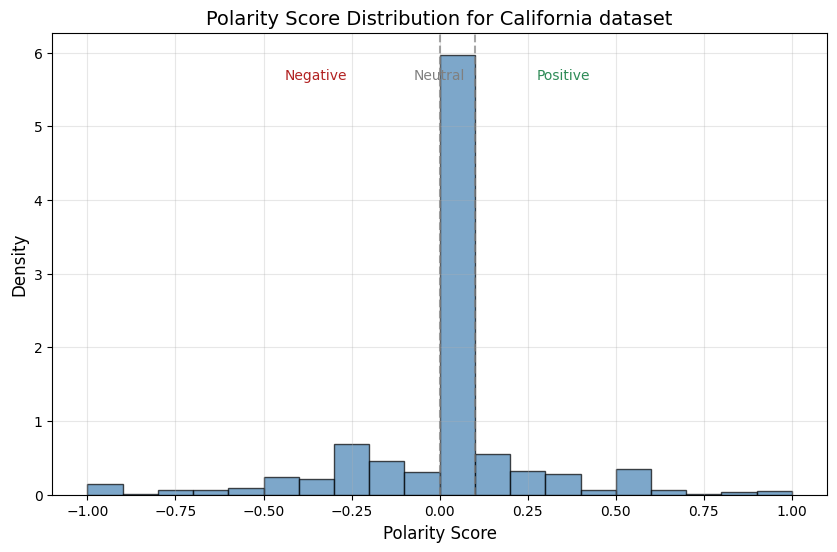

In [26]:
#Testing sentiment on california dataset, and graphing

cali_df = pd.read_json("../data/california_wildfires_final_data.json")
cali_df = cali_df[["tweet_id", "tweet_text"]]

cali_df.loc[:, ["disasters", "locations", "sentiment", "polarity"]] = cali_df["tweet_text"].apply(
    lambda x: pd.Series(extract_ent_sent(x))
)

#print(cali_df.head())

#get scores
scores = cali_df["polarity"].values
avg_scores = cali_df["polarity"].mean()
scores_std = cali_df["polarity"].std()
sentiment = cali_df["sentiment"].values
print(np.unique(sentiment, return_counts=True))
print(f"AVG: {avg_scores}\nSTD: {scores_std}")

# Create figure
plt.figure(figsize=(10, 6))

# Plot histogram
plt.hist(scores, bins=20, range=(-1, 1), 
         edgecolor='black', alpha=0.7, 
         color='steelblue', density=True)

# Add labels and style
plt.title('Polarity Score Distribution for California dataset', fontsize=14)
plt.xlabel('Polarity Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, alpha=0.3)

# Add reference lines for typical sentiment thresholds
plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(0.1, color='gray', linestyle='--', alpha=0.7)
plt.text(-0.35, plt.ylim()[1]*0.9, 'Negative', ha='center', color='firebrick')
plt.text(0, plt.ylim()[1]*0.9, 'Neutral', ha='center', color='gray')
plt.text(0.35, plt.ylim()[1]*0.9, 'Positive', ha='center', color='seagreen')

plt.show()

In [55]:
# process all datasets together for dash demo
try:
    print("Processing datasets...")
    df.loc[:, ["disasters", "locations", "sentiment", "polarity"]] = df["tweet_text"].apply(
        lambda x: pd.Series(extract_ent_sent(x))
    )
except Exception as e:
    print(f"Failed to process all datasets: {e}")

Processing datasets...
Failed to process all datasets: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


In [28]:
#adding sentiment average

exploded = df.explode("disasters").explode('locations').dropna()
# new stuff
#print(df.head())
#print(df[df.sentiment != 'Neutral'].head())

#filtering all neutral counts to just get average of pos - neg values
filtered = df[df.sentiment != 'Neutral'].explode("disasters").explode('locations').dropna()

crisis_counts = (
    filtered.groupby(["disasters", "locations"])
    .agg(
        count=('disasters', 'size'),
        avg_sentiment=('polarity', 'mean')
    )
    .reset_index()
    .sort_values("count", ascending=False)
    .round({'avg_sentiment': 2})
)

print(crisis_counts)


      disasters    locations  count  avg_sentiment
202    wildfire   california    250          -0.04
49   earthquake       mexico    204          -0.04
34   earthquake         iran    128          -0.01
35   earthquake         iraq     88          -0.01
53   earthquake  mexico city     56          -0.01
..          ...          ...    ...            ...
231    wildfire       topeka      1           0.70
230    wildfire       states      1          -0.24
235    wildfire      weather      1          -0.20
236    wildfire    wisconsin      1          -0.20
237    wildfire     yosemite      1           0.10

[238 rows x 4 columns]


In [29]:
# calculating severity:
mean = crisis_counts["count"].mean()
std = crisis_counts["count"].std()

#z score
crisis_counts["severity"] = (crisis_counts["count"] - mean) / std

print(crisis_counts)

      disasters    locations  count  avg_sentiment   severity
202    wildfire   california    250          -0.04  10.561650
49   earthquake       mexico    204          -0.04   8.579904
34   earthquake         iran    128          -0.01   5.305715
35   earthquake         iraq     88          -0.01   3.582457
53   earthquake  mexico city     56          -0.01   2.203851
..          ...          ...    ...            ...        ...
231    wildfire       topeka      1           0.70  -0.165628
230    wildfire       states      1          -0.24  -0.165628
235    wildfire      weather      1          -0.20  -0.165628
236    wildfire    wisconsin      1          -0.20  -0.165628
237    wildfire     yosemite      1           0.10  -0.165628

[238 rows x 5 columns]


In [30]:
# convert to json and store in a file

print(crisis_counts)
csv = crisis_counts.to_csv('./demo/crisis_counts.csv', index=False)
print(csv)

      disasters    locations  count  avg_sentiment   severity
202    wildfire   california    250          -0.04  10.561650
49   earthquake       mexico    204          -0.04   8.579904
34   earthquake         iran    128          -0.01   5.305715
35   earthquake         iraq     88          -0.01   3.582457
53   earthquake  mexico city     56          -0.01   2.203851
..          ...          ...    ...            ...        ...
231    wildfire       topeka      1           0.70  -0.165628
230    wildfire       states      1          -0.24  -0.165628
235    wildfire      weather      1          -0.20  -0.165628
236    wildfire    wisconsin      1          -0.20  -0.165628
237    wildfire     yosemite      1           0.10  -0.165628

[238 rows x 5 columns]
None
